In [1]:
from lib import *
%matplotlib inline


In [2]:
print(f"Зафиксируем рандом сид для воспроизводимости результатов: {random_seed}")


Зафиксируем рандом сид для воспроизводимости результатов: 50


# Загружаю данные

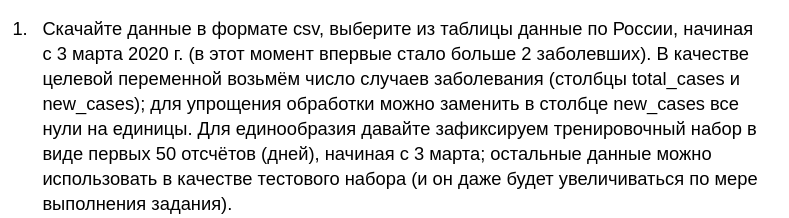

In [3]:
# загружаем датасет
# закоментируйте, если у вас уже есть этот датасет локально
# !wget -q https://covid.ourworldindata.org/data/owid-covid-data.csv


In [4]:
# Загружаю датасет
raw_full_data = pd.read_csv("owid-covid-data.csv")
raw_full_data["date"] = pd.to_datetime(raw_full_data["date"], format="%Y-%m-%d")

# Выбираю только Россию и данные с 3-его марта 2020-ого года
raw_full_data = raw_full_data[
    (raw_full_data["location"] == "Russia") & (raw_full_data["date"] >= third_march)
]

# Нумерую индекс от 0, чтоб было проще взять первые 50 дней
# и делю данные на трейн и тест
raw_full_data.reset_index(drop=True, inplace=True)
raw_full_data = raw_full_data[["date", "total_cases", "new_cases"]]
raw_full_data["day_num"] = np.array(raw_full_data.index) + 1

train_data = raw_full_data[raw_full_data.index < 50].copy()
test_data = raw_full_data[raw_full_data.index >= 50].copy()

print(
    f"Train\nДанные о России в период с {train_data.iloc[0]['date']} по {train_data.iloc[49]['date']}"
)
print(
    f"Test\nДанные о России в период с {test_data.iloc[0]['date']} по {test_data.iloc[-1]['date']}"
)

# Вывожу оставшиеся данные на экран
display(train_data.shape, test_data.shape)
display(train_data.head(), test_data.head())


Train
Данные о России в период с 2020-03-03 00:00:00 по 2020-04-21 00:00:00
Test
Данные о России в период с 2020-04-22 00:00:00 по 2022-03-04 00:00:00


(50, 4)

(682, 4)

,date,total_cases,new_cases,day_num
0,2020-03-03,3.0,0.0,1
1,2020-03-04,3.0,0.0,2
2,2020-03-05,4.0,1.0,3
3,2020-03-06,13.0,9.0,4
4,2020-03-07,13.0,0.0,5


,date,total_cases,new_cases,day_num
50,2020-04-22,57999.0,5236.0,51
51,2020-04-23,62773.0,4774.0,52
52,2020-04-24,68622.0,5849.0,53
53,2020-04-25,74588.0,5966.0,54
54,2020-04-26,80949.0,6361.0,55


In [5]:
print("Пустых значений в данных нет. Это не может не радовать)")
display(train_data.isna().sum(), test_data.isna().sum())


Пустых значений в данных нет. Это не может не радовать)


date           0
total_cases    0
new_cases      0
day_num        0
dtype: int64

date           0
total_cases    0
new_cases      0
day_num        0
dtype: int64

## 2.0 Построим графики роста количества заболеваний на трейне и тесте.

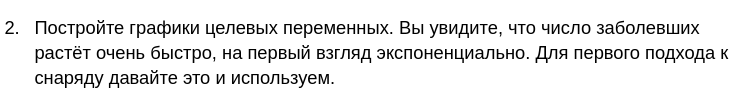


**Добавил для сравнения рядом график экспоненты с вручную подобранными константами**

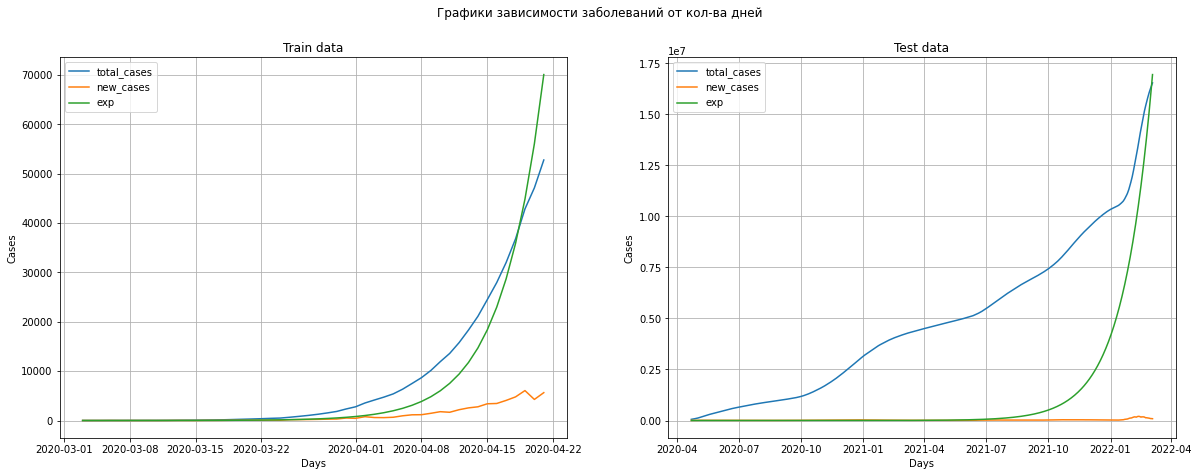

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Графики зависимости заболеваний от кол-ва дней")

ax1.grid("black")
ax1.set_title("Train data")
ax1.set_xlabel("Days")
ax1.set_ylabel("Cases")
ax1.plot(train_data["date"], train_data["total_cases"], label="total_cases")
ax1.plot(train_data["date"], train_data["new_cases"], label="new_cases")
ax1.plot(train_data["date"], 1.25 ** train_data["day_num"], label="exp")
ax1.legend()

ax2.grid("black")
ax2.set_title("Test data")
ax2.set_xlabel("Days")
ax2.set_ylabel("Cases")
ax2.plot(test_data["date"], test_data["total_cases"], label="total_cases")
ax2.plot(test_data["date"], test_data["new_cases"], label="new_cases")
ax2.plot(test_data["date"], 1.023 ** test_data["day_num"], label="exp")
ax2.legend()

plt.show()


## 2.1. Обучим линейную регрессию на экспоненте от трейна

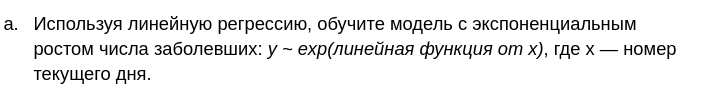

Вот так почему-то сработало плохо

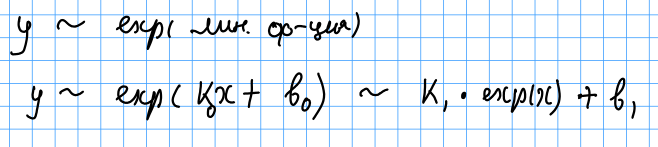

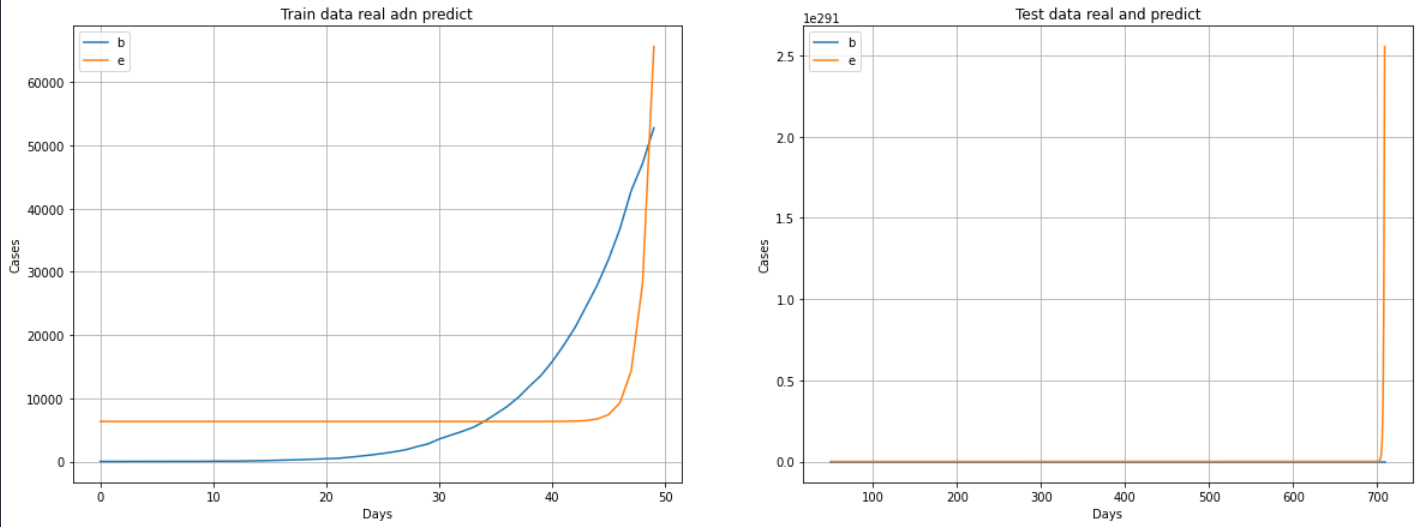

Решил попробовать пойти таким путём.

И этот путь решения даёт графики/аппроксимацию на тренировочных данных намного лучше.

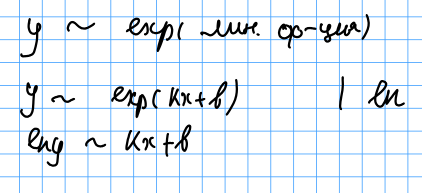

Рост ~экспоненциальный только у **total_cases**(обучать линейную регрессию на экспоненте для **new_cases** не имеет особого смысла).
Поэтому я обучу линейную регрессию только для **total_cases**.

**+** По сути это временной ряд. Для временных рядов для гомоскедастичности и других приятных плюшек обычно берут k-ые разности. **new_cases** по сути есть k-ая разница с k=1. Это, скорее всего, будет работать лучше, потому что мы можем предсказывать **new_cases** и потом брать от него cum sum.


Логарифмирую **total_cases**.


In [7]:
# первый номер дня = 0, второй = 1. логарифму не нравится, поэтому обрублю их
train_data["log_total_cases"] = np.log(train_data["total_cases"])
test_data["log_total_cases"] = np.log(test_data["total_cases"])

display(
    train_data.head(),
    test_data.head(),
)


,date,total_cases,new_cases,day_num,log_total_cases
0,2020-03-03,3.0,0.0,1,1.098612
1,2020-03-04,3.0,0.0,2,1.098612
2,2020-03-05,4.0,1.0,3,1.386294
3,2020-03-06,13.0,9.0,4,2.564949
4,2020-03-07,13.0,0.0,5,2.564949


,date,total_cases,new_cases,day_num,log_total_cases
50,2020-04-22,57999.0,5236.0,51,10.968181
51,2020-04-23,62773.0,4774.0,52,11.047280
52,2020-04-24,68622.0,5849.0,53,11.136368
53,2020-04-25,74588.0,5966.0,54,11.219735
54,2020-04-26,80949.0,6361.0,55,11.301575


Создаю и обучаю модель линейной регрессии для **log_total_cases** на номерах дней.

In [8]:
model_first = LinearRegression(
    n_jobs=-1,
)
model_first.fit(
    train_data["day_num"].values.reshape(-1, 1), train_data["log_total_cases"]
)


LinearRegression(n_jobs=-1)

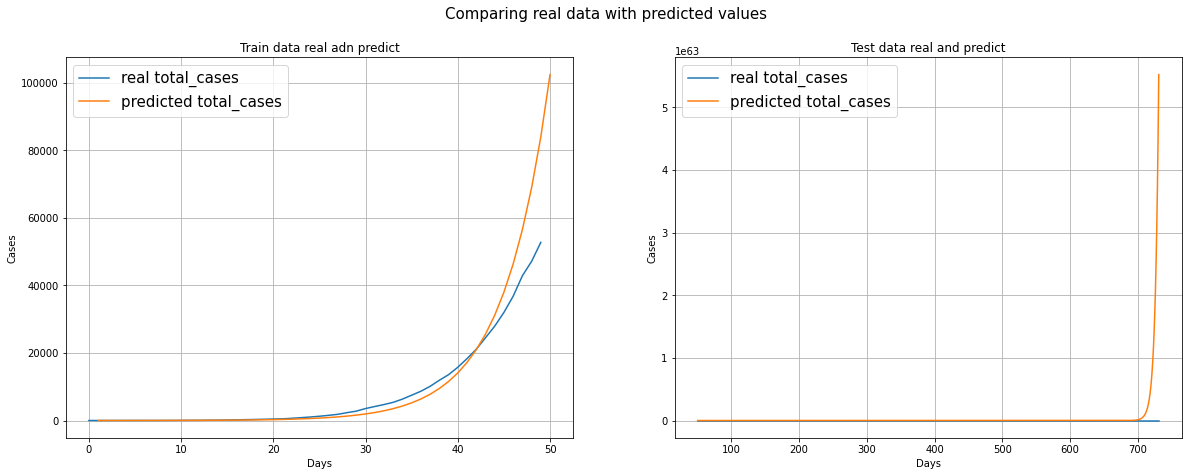

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Comparing real data with predicted values", fontsize=15)

ax1.grid("black")
ax1.set_title("Train data real adn predict")
ax1.set_xlabel("Days")
ax1.set_ylabel("Cases")
ax1.plot(train_data.index, train_data["total_cases"], label="real total_cases")
ax1.plot(
    train_data["day_num"],
    np.exp(model_first.predict(train_data["day_num"].values.reshape(-1, 1))),
    label="predicted total_cases",
)
ax1.legend(fontsize=15)

ax2.grid("black")
ax2.set_title("Test data real and predict")
ax2.set_xlabel("Days")
ax2.set_ylabel("Cases")
ax2.plot(test_data.index, test_data["total_cases"], label="real total_cases")
ax2.plot(
    test_data.index,
    np.exp(model_first.predict(test_data["day_num"].values.reshape(-1, 1))),
    label="predicted total_cases",
)
ax2.legend(fontsize=15)

plt.show()


Наша модель даже на тренировочных данных с какого-то момента(~40-ой день после 3-его марта) превышает реальное число больных.

Для наших тестовых данных эта модель уже вообще не годится. Чтобы использовать модель для предсказания, нужно переобучать её каждую неделю, а лучше каждый день.

## 2.2. 

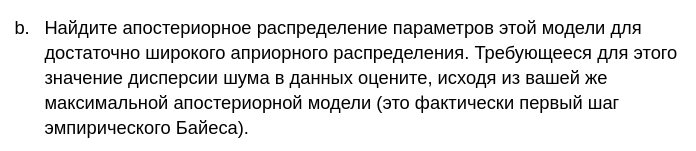

Дисперсия - мат. ожидание отклонения от мат. ожидания(среднего).

Буду считать среднее квадрата отклонения предсказания модели от истинных значений.


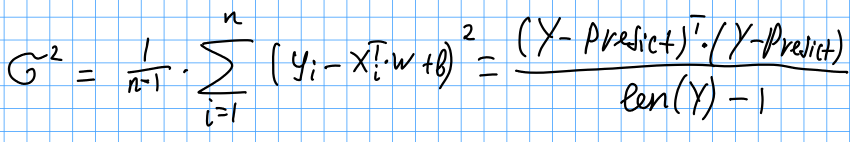

In [10]:
predict_first = model_first.predict(train_data["day_num"].values.reshape(-1, 1))
dif = train_data["log_total_cases"] - predict_first
var = count_var(dif)
print(f"Variance = {round(var, 5)}")


Variance = 0.12432


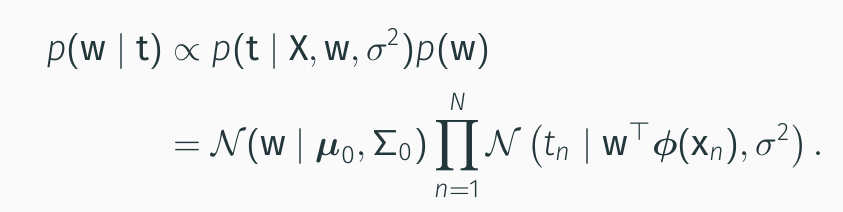

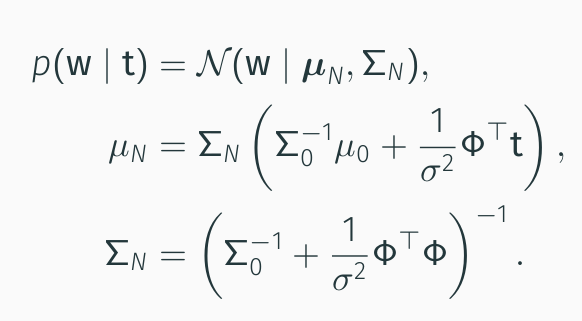

Я так подумал.


1. Возьму маленьку альфу => умножу диагональную матртцу на большое число
2. Слабая регуляризация ~ нет регуляризации


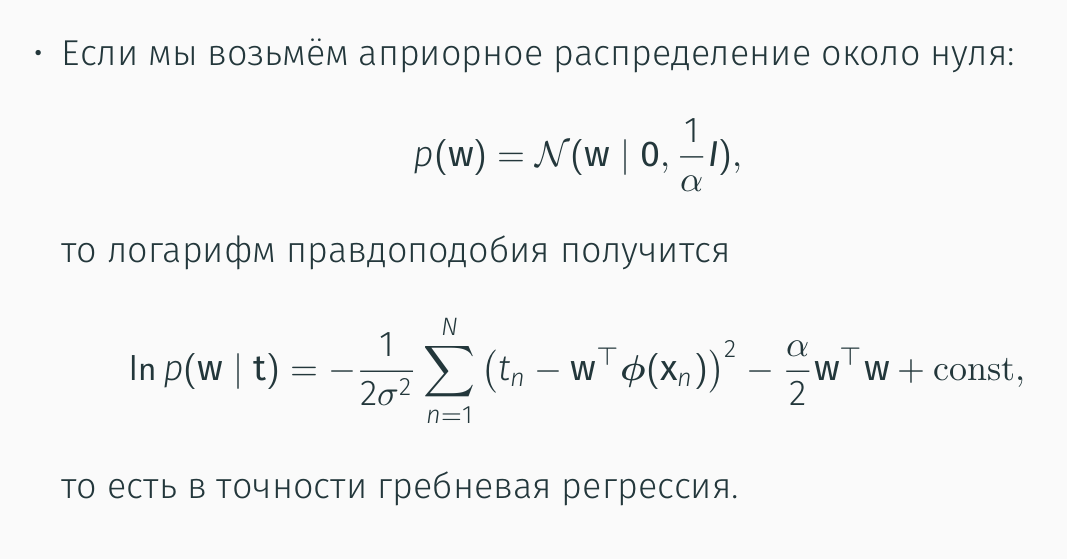

In [11]:
X_data = np.hstack(
    [
        np.ones(train_data.shape[0]).reshape(-1, 1),
        np.array(train_data["day_num"]).reshape(-1, 1),
    ]
)
prior = (
    np.zeros(2),
    np.eye(2) * 1e3,
)

mu, sigma = count_posterior(
    prior=prior,
    var=var,
    X=X_data,
    Y=train_data["log_total_cases"],
)


In [12]:
print(f"Sigma_n:\n{sigma}\n")
print(f"Mu_n:\n{mu}")


Sigma_n:
[[ 1.02496879e-02 -3.04446176e-04]
 [-3.04446176e-04  1.19390954e-05]]

Mu_n:
[1.62242967 0.1982914 ]


## 2.3

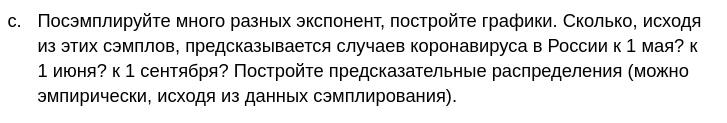

In [13]:
sample_amount = int(5e2)
w_samp = np.random.multivariate_normal(mu, sigma, sample_amount)
y_samp = [
    np.exp(np.array([np.ones(train_data.shape[0]), train_data["day_num"].values]).T @ w)
    for w in w_samp
]


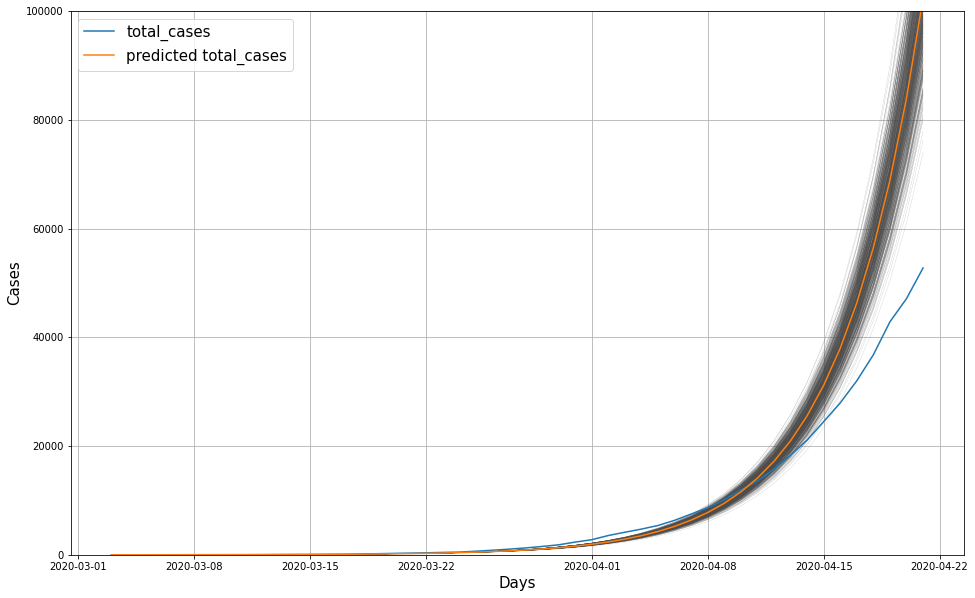

In [14]:
plt.figure(figsize=(16, 10))

plt.ylim(0, 1e5)
# y samples
for n in range(sample_amount):
    plt.plot(train_data["date"], y_samp[n], color="0.3", linewidth=0.1)

# real num of cases by day
plt.plot(train_data["date"], train_data["total_cases"], label="total_cases")
# мой predict
plt.plot(train_data["date"], np.exp(predict_first), label="predicted total_cases")

plt.legend(fontsize=15)
plt.grid("black")
plt.xlabel("Days", fontsize=15)
plt.ylabel("Cases", fontsize=15)
plt.show()


### Построю распределение предсказаний моделей на 1 мая, 1 июня, 1 сентября.

In [15]:
first_may_in_day_num = (datetime(2020, 5, 1) - third_march).days
first_june_in_day_num = (datetime(2020, 6, 1) - third_march).days
first_sep_in_day_num = (datetime(2020, 9, 1) - third_march).days


In [16]:
first_days_data = np.array(
    [
        np.ones(3),
        [first_may_in_day_num, first_june_in_day_num, first_sep_in_day_num],
    ]
)
fitst_days_data = np.array(
    [np.ones(3), [first_may_in_day_num, first_june_in_day_num, first_sep_in_day_num]]
)
first_may_predict, first_june_predict, first_sep_predict = tuple(
    np.exp(w_samp @ first_days_data).T
)


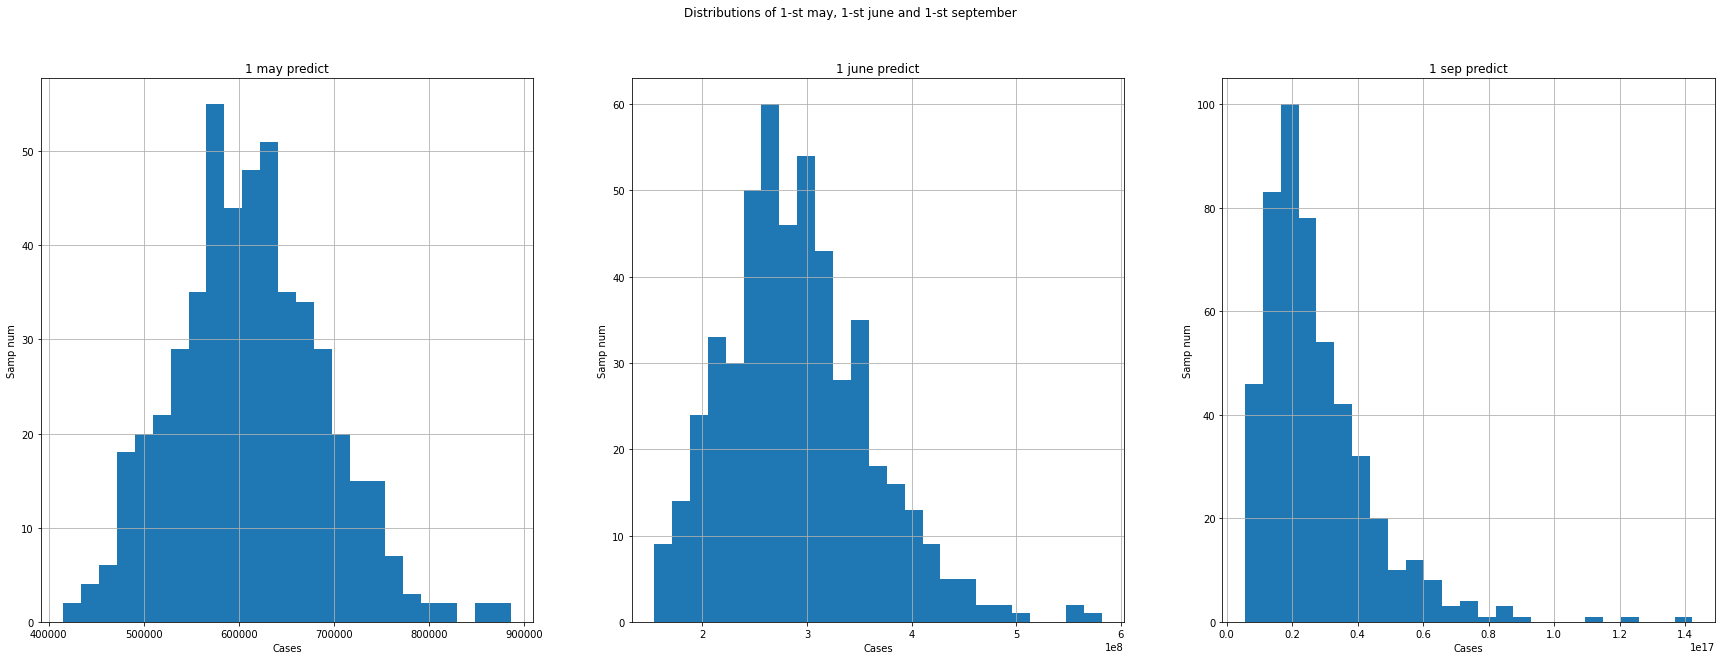

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle("Distributions of 1-st may, 1-st june and 1-st september")

ax1.grid("black")
ax1.set_title("1 may predict")
ax1.set_xlabel("Cases")
ax1.set_ylabel("Samp num")
ax1.hist(first_may_predict, bins=25)

ax2.grid("black")
ax2.set_title("1 june predict")
ax2.set_xlabel("Cases")
ax2.set_ylabel("Samp num")
ax2.hist(first_june_predict, bins=25)

ax3.grid("black")
ax3.set_title("1 sep predict")
ax3.set_xlabel("Cases")
ax3.set_ylabel("Samp num")
ax3.hist(first_sep_predict, bins=25)

plt.show()


In [18]:
print(
    "Наша модель, обученная на первых 50-ти днях, начиная 3-его марта,",
    "\n",
    "предсказывает такие значения заболевших на 1 мая, 1 июня и 1 сентября",
)
print(
    f"\t1 мая: {np.format_float_scientific(np.exp(model_first.predict(np.array(first_may_in_day_num).reshape(-1,1))))} заболевших\n",
    f"\t1 июня: {np.format_float_scientific(np.exp(model_first.predict(np.array(first_june_in_day_num).reshape(-1,1))))} заболевших\n",
    f"\t1 сентября: {np.format_float_scientific(np.exp(model_first.predict(np.array(first_sep_in_day_num).reshape(-1,1))))} заболевших\n",
)


Наша модель, обученная на первых 50-ти днях, начиная 3-его марта, 
 предсказывает такие значения заболевших на 1 мая, 1 июня и 1 сентября
	1 мая: 6.102415029447825e+05 заболевших
 	1 июня: 2.8517920972746694e+08 заболевших
 	1 сентября: 2.3869843564137116e+16 заболевших



# 3.

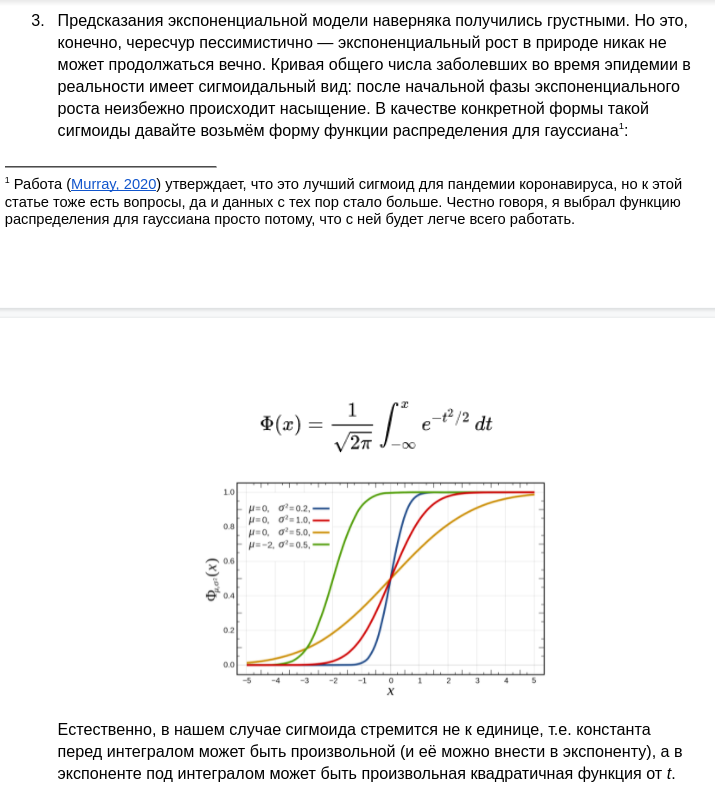

## 3.1

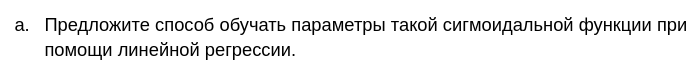

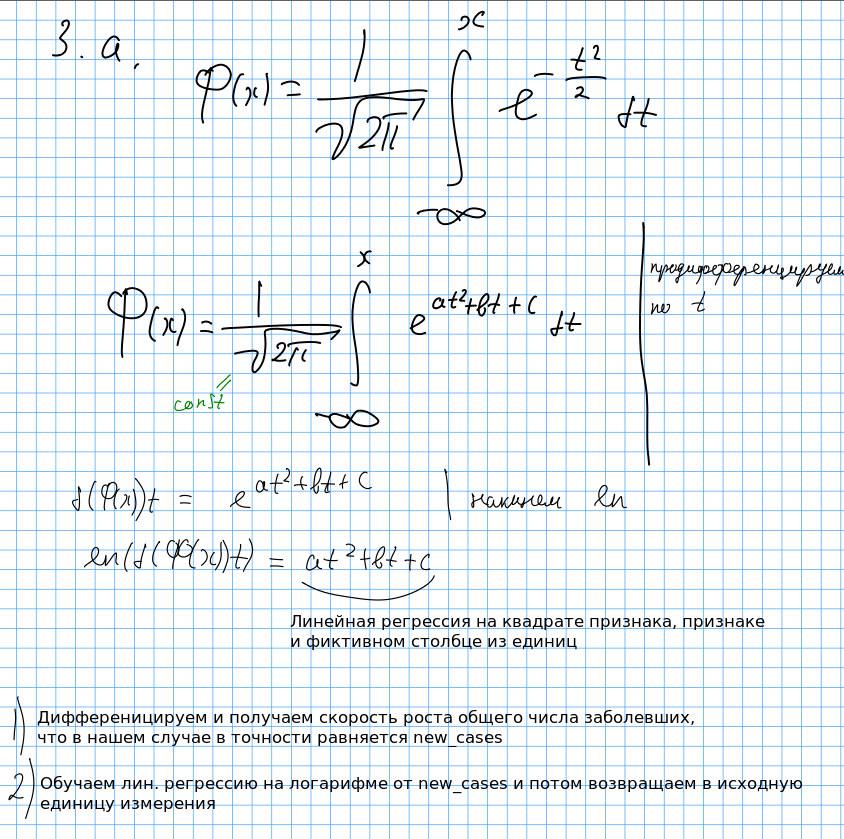

## 3.2

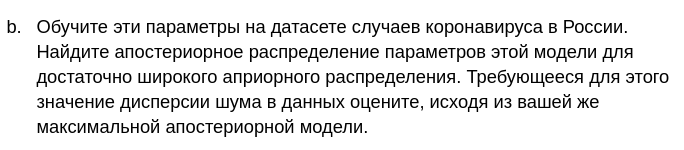

Делаем читверство

In [19]:
train_data["new_cases"].replace(0, 1, inplace=True)
test_data["new_cases"].replace(0, 1, inplace=True)
raw_full_data["new_cases"].replace(0, 1, inplace=True)


Добавляю столбец логарифма от **new_cases** и квадрат номера дня

In [20]:
# логарифм от new_cases
train_data["log_new_cases"] = np.log(train_data["new_cases"].values)
test_data["log_new_cases"] = np.log(test_data["new_cases"].values)
raw_full_data["log_new_cases"] = np.log(raw_full_data["new_cases"].values)

# квадрат логарифма от new_cases
train_data["square_day_num"] = train_data["day_num"].values ** 2
test_data["square_day_num"] = test_data["day_num"].values ** 2
raw_full_data["square_day_num"] = raw_full_data["day_num"].values ** 2


In [21]:
# Создаю модель
model_second = LinearRegression(
    n_jobs=-1,
)

# подготавливаю данные для обучения
X_data = train_data[["square_day_num", "day_num"]].values
Y = train_data["log_new_cases"].values

# обучаю модель
model_second.fit(
    X=X_data,
    y=Y,
)

predict_second_train = model_second.predict(X_data)
predict_second_test = model_second.predict(
    test_data[["square_day_num", "day_num"]].values
)


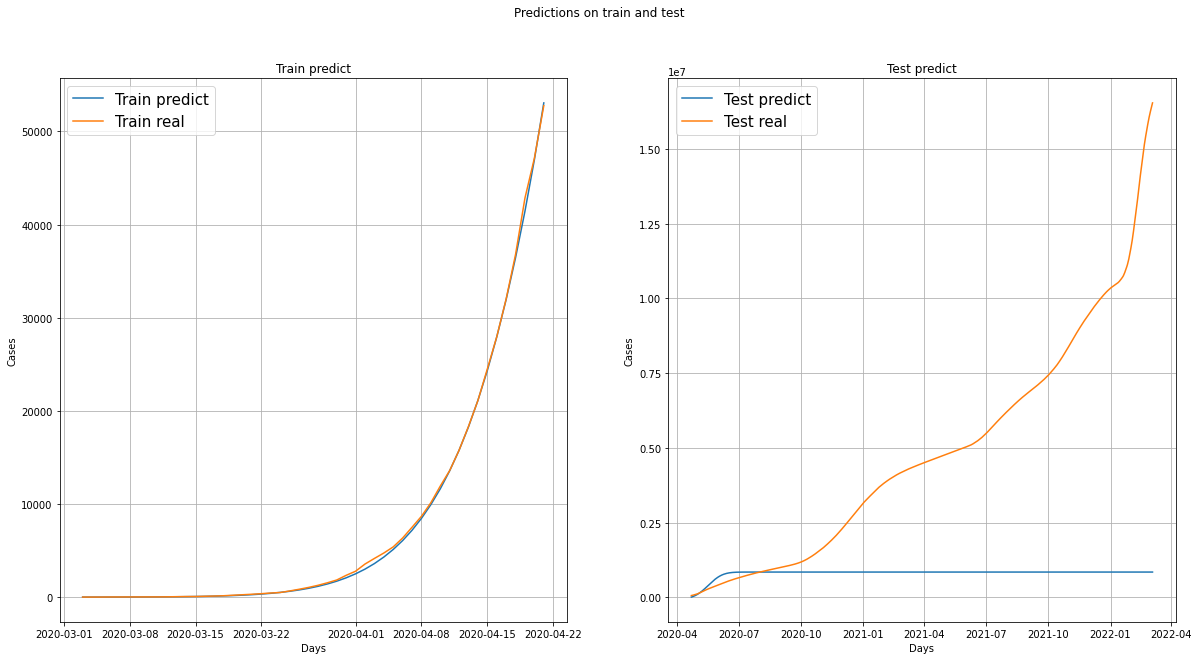

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Predictions on train and test")

ax1.grid("black")
ax1.set_title("Train predict")
ax1.set_xlabel("Days")
ax1.set_ylabel("Cases")
# ax1.set_yscale("log")
ax1.plot(
    train_data["date"], np.cumsum(np.exp(predict_second_train)), label="Train predict"
)
ax1.plot(train_data["date"], train_data["total_cases"], label="Train real")
ax1.legend(fontsize=15)


ax2.grid("black")
ax2.set_title("Test predict")
ax2.set_xlabel("Days")
ax2.set_ylabel("Cases")
# ax2.set_yscale("log")
ax2.plot(
    test_data["date"], np.cumsum(np.exp(predict_second_test)), label="Test predict"
)
ax2.plot(test_data["date"], test_data["total_cases"], label="Test real")
ax2.legend(fontsize=15)

plt.show()


/home/bovrrr/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


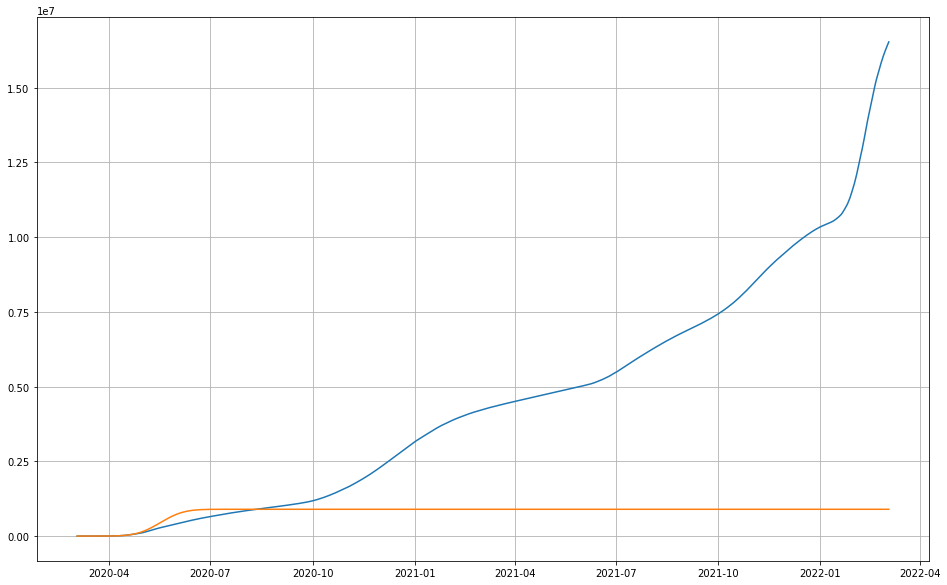

In [23]:
plt.figure(figsize=(16, 10))
plt.grid("black")
plt.plot(raw_full_data["date"], raw_full_data["total_cases"], label="Real data")
plt.plot(
    raw_full_data["date"],
    np.cumsum(
        np.exp(model_second.predict(raw_full_data[["square_day_num", "day_num"]]))
    ),
    label="Predict",
)
plt.show()


1. Как мы видим, из-за того, что мы учились только на первых 50 днях, следующие почти 700 предсказываются не особо хорошо.

У сигмоиды происходит насыщение и она не растёт дальше.

2. Но зато на трейне предсказания очень и очень точны.

Мне понравилось то, как мы можем использовать такую простую, на первый взгляд, модель для таких сложных зависимостей. 

(жалко, конечно, нельзя так просто всегда находить спрямшляющее пространство для нелинейных изначально зависимостей между признаками и целевой переменной)


In [24]:
dif = train_data["log_new_cases"] - predict_second_train
var = count_var(dif)
print(f"Variance = {round(var, 5)}")


Variance = 0.24417


In [25]:
X_data = np.array(
    [
        np.ones(train_data.shape[0]),
        train_data["square_day_num"],
        train_data["day_num"],
    ]
)

prior = tuple([np.zeros(3), np.eye(3) * 5e3])
mu, sigma = count_posterior(
    prior=prior,
    var=var,
    X=X_data.T,
    Y=Y,
)


In [26]:
print(f"Sigma_n:\n{sigma}\n")
print(f"Mu_n:\n{mu}")


Sigma_n:
[[ 4.76625715e-02  6.22877289e-05 -3.77463641e-03]
 [ 6.22877289e-05  1.40923033e-07 -7.18706720e-06]
 [-3.77463641e-03 -7.18706720e-06  3.89989697e-04]]

Mu_n:
[-0.67403639 -0.00182978  0.27928188]


## 3.3

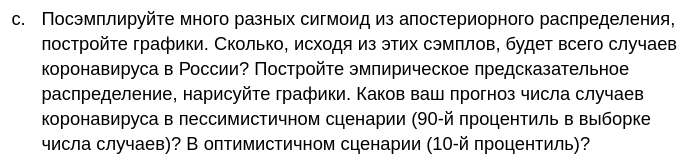

In [27]:
w_samp = np.random.multivariate_normal(mu, sigma, sample_amount)
y_samp = [
    np.exp(
        np.array(
            [
                np.ones(raw_full_data.shape[0]),
                raw_full_data["square_day_num"].values,
                raw_full_data["day_num"].values,
            ]
        ).T
        @ w
    )
    for w in w_samp
]


/home/bovrrr/.local/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


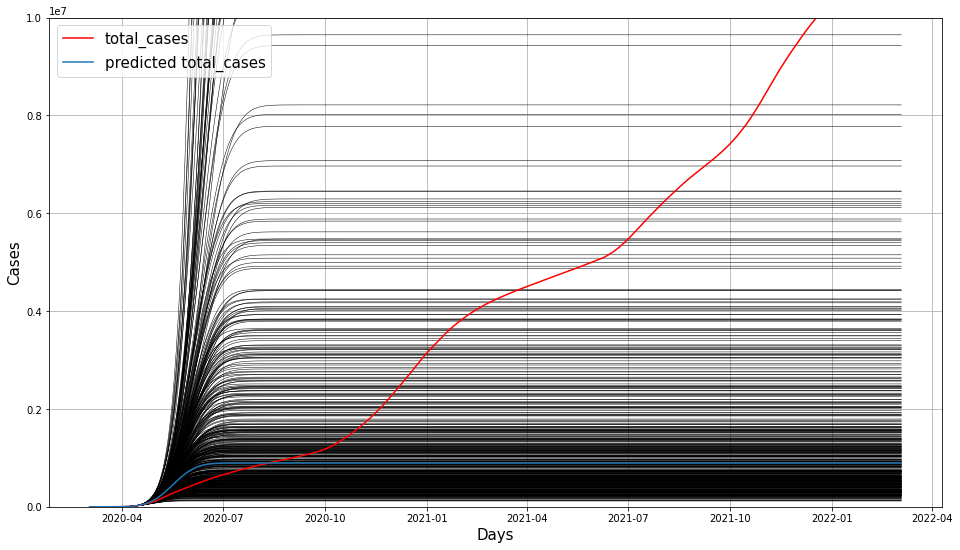

In [28]:
plt.figure(figsize=(16, 9))

plt.ylim(0, 1e7)

for i in range(sample_amount):
    plt.plot(raw_full_data["date"], np.cumsum(y_samp[i]), color="black", linewidth=0.5)

plt.plot(
    raw_full_data["date"],
    raw_full_data["total_cases"],
    label="total_cases",
    color="red",
)
plt.plot(
    raw_full_data["date"],
    np.exp(model_second.predict(raw_full_data[["square_day_num", "day_num"]])).cumsum(),
    label="predicted total_cases",
)

plt.legend(fontsize=15)
plt.grid("black")
plt.xlabel("Days", fontsize=15)
plt.ylabel("Cases", fontsize=15)
plt.show()


**Посмотрим на гистограмму максимальных значений сигмоид**(нужно ещё добавить экспоненту и взять cumsum. Когда я это делал и пытался построить графики, они либо не строились из-за бесконечностей, либо, если я их убирал, выходили просто пустые графики с сеткой)

In [29]:
preds_final = np.array([np.exp(y).cumsum() for y in y_samp])


/tmp/ipykernel_106650/3689998792.py:1: RuntimeWarning: overflow encountered in exp
  preds_final = np.array([np.exp(y).cumsum() for y in y_samp])


In [30]:
def plot_month_distr(day_num, y_samp):
    plt.figure(figsize=(16, 9))
    plt.hist([y[day_num] for y in y_samp], bins=100)
    plt.grid("black")
    plt.show()



Распределение прогнозов на 1 мая 2020

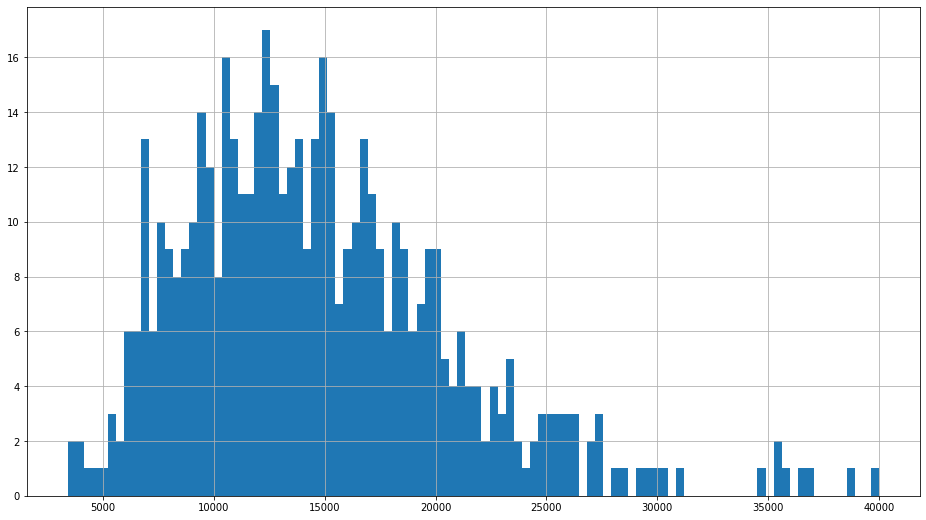

In [31]:
plot_month_distr(first_may_in_day_num, y_samp)


Распределение прогнозов на 1 июня 2020

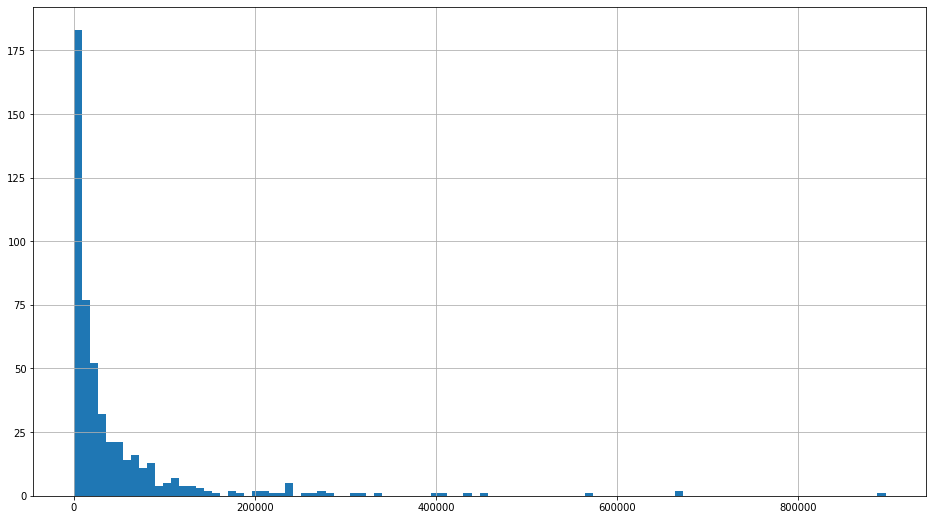

In [32]:
plot_month_distr(first_june_in_day_num, y_samp)


Распределение прогнозов на 1 сентября 2020

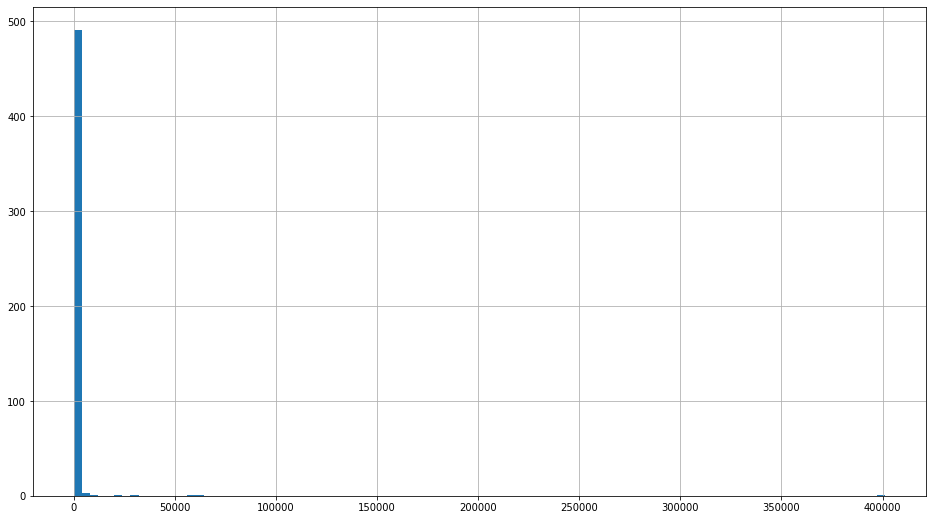

In [33]:
plot_month_distr(first_sep_in_day_num, y_samp)


Распределение прогнозов на насыщение.

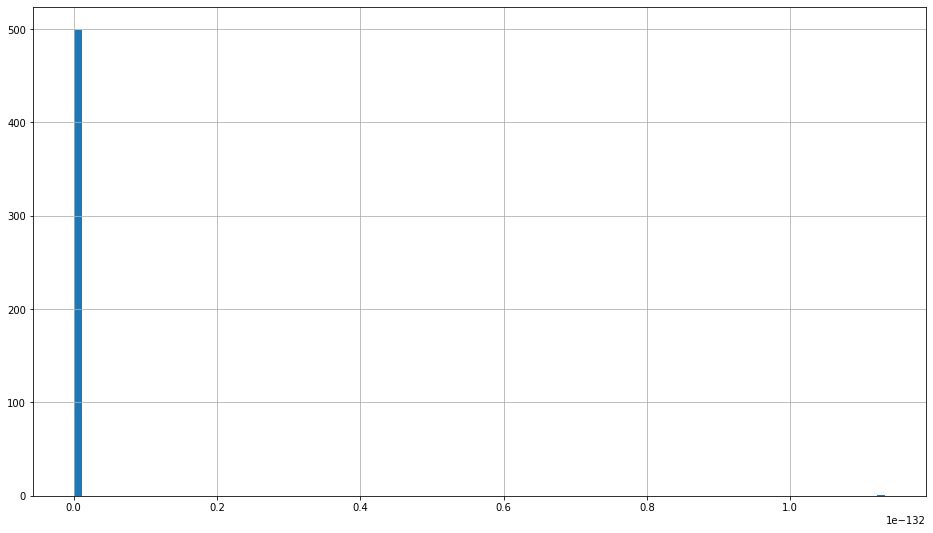

In [34]:
plot_month_distr(y_samp[0].size - 1, y_samp)


Посмотрим на оптимистичный и пессимистичный случаи заболеваемости по оценке нашей модели

In [35]:
# посчитаю какой день можно взять, чтоб там было уже насыщение, но не было np.inf
(datetime(2020, 10, 1) - third_march).days


212

In [36]:
def estim_preds(sample, perc):
    sample_red = [i for i in sample if i != np.inf]
    sample_red = sorted(sample)
    len_ = len(sample_red)
    perc_int = int(len_ * perc)
    return int(sample_red[perc_int])


print(
    f"В пессимистичном случае(90%) мы получаем насыщение при {estim_preds([y[y.size -1] for y in preds_final], 0.9)} числе заболевших."
)
print(
    f"В оптимистичном случае(10%) мы получаем насыщение при {estim_preds([y[y.size-1] for y in preds_final], 0.1)} числе заболевших."
)


OverflowError: cannot convert float infinity to integer

Не буду оправдываться(Ну чуть-чуть если только. Из академ. отпуска вышел в универе, в Казань с Казахстана переезжал, документы, необходимые для пребывания и работы(в ИИ лабораторию СБЕР'а прошёл), оформляю.). Поздно сел за домашнюю работу, не успел разобраться этой ошибкой.

Извините! Курс у Вас очень интересный.

Что я понял!

1. Чем больше имеется точек данных, тем меньшую роль играет априорное распределение, потому что правдоподобие его "забивает".
2. На собеседованиях меня теперь сложнее завалить на линейных моделях.
3. Чем дальшы мы от данных, на которых мы обучались, тем менее мы уверенны в предсказании.
4. Сигмоида имеет момент насыщения. Скорее всего, это можно расценивать как нижнюю оценку на какое-то ближайшее время. Если мы видим, что значение насыщения сигмоиды первышает 80-90 % койкомест в больницах страны, то нужно водить карантин и жёсткие меры. Ведь главная задача - это не допустить переполнения трафика здрав. системы страны.
5. Ещё я стал намного лучше в графиках). Хочу ещё больше углубиться в визуализацию данных.
